# 1. Importing the dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import randint, uniform
import shap

# 2. Data Loading and Understanding

In [2]:
df = pd.read_csv("dataset/train.csv")

In [3]:
df.shape

(125000, 20)

In [4]:
df.head(5)

,customer_id,age,location,subscription_type,payment_plan,num_subscription_pauses,payment_method,customer_service_inquiries,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,num_shared_playlists,notifications_clicked,churned
0,1,32,Montana,Free,Yearly,2,Paypal,Medium,-1606,22.391362,105.394516,0.176873,169,109,18,32,52,35,46,0
1,2,64,New Jersey,Free,Monthly,3,Paypal,Low,-2897,29.294210,52.501115,0.981811,55,163,44,33,12,25,37,1
2,3,51,Washington,Premium,Yearly,2,Credit Card,High,-348,15.400312,24.703696,0.048411,244,117,20,129,50,28,38,0
3,4,63,California,Family,Yearly,4,Apple Pay,Medium,-2894,22.842084,83.595480,0.035691,442,252,47,120,55,17,24,0
4,5,54,Washington,Family,Monthly,3,Paypal,High,-92,23.151163,52.578266,0.039738,243,230,41,66,40,32,47,0


- **customer_id** - a unique customer identification number
- **age** - the age of the user
- **location** - the US state of the user
- **subscription_type** - type of subsciption
- **payment_plan** - how often the user pays, monthly of annually
- **num_subscription_pauses** - number of times the user has paused their subscription (max 2)
- **payment_method** - form of user payment
- **customer_service_inquiries** - the frequency of customer service inquiries from the user
- **signup_date** - date the user signed up for the music subscription service
- **weekly_hours** - average number of weekly listening hours
- **average_session_length** - average length of each music listening session (in hours)
- **song_skip_rate** - percentage of songs the user does not finish
- **weekly_songs_played** - average number of songs the user plays in a week
- **weekly_unique_songs** - average number of unique songs the user plays in a week
- **num_favorite_artists** - number of artists the user set as favorite artists
- **num_platform_friends** - number of user connections in the app
- **num_playlists_created** - number of playlists the user created
- **num_shared_playlists** - number of playlists that are shared publicly
- **notifications_clicked** - number of in-app notifications clicked on
- **churned** - this is the target variable, 0 = customer is active, 1 = customer churned

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   customer_id                 125000 non-null  int64  
 1   age                         125000 non-null  int64  
 2   location                    125000 non-null  object 
 3   subscription_type           125000 non-null  object 
 4   payment_plan                125000 non-null  object 
 5   num_subscription_pauses     125000 non-null  int64  
 6   payment_method              125000 non-null  object 
 7   customer_service_inquiries  125000 non-null  object 
 8   signup_date                 125000 non-null  int64  
 9   weekly_hours                125000 non-null  float64
 10  average_session_length      125000 non-null  float64
 11  song_skip_rate              125000 non-null  float64
 12  weekly_songs_played         125000 non-null  int64  
 13  weekly_unique_

In [6]:
# dropping customer id as it is not important for our training
df = df.drop(columns = ["customer_id"])
df.head(2)

,age,location,subscription_type,payment_plan,num_subscription_pauses,payment_method,customer_service_inquiries,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,num_shared_playlists,notifications_clicked,churned
0,32,Montana,Free,Yearly,2,Paypal,Medium,-1606,22.391362,105.394516,0.176873,169,109,18,32,52,35,46,0
1,64,New Jersey,Free,Monthly,3,Paypal,Low,-2897,29.294210,52.501115,0.981811,55,163,44,33,12,25,37,1


In [7]:
# printing the unique values in all the columns
categorical_features = ["location", "subscription_type", "payment_plan", "num_subscription_pauses", "payment_method", "customer_service_inquiries", "churned"]
for col in df.columns:
    if col in categorical_features:
        print(col, df[col].unique())
        print("-"*80)

location ['Montana' 'New Jersey' 'Washington' 'California' 'Georgia' 'Wisconsin'
 'Idaho' 'New York' 'Alabama' 'South Carolina' 'North Carolina' 'Utah'
 'West Virginia' 'Maine' 'Nebrasksa' 'Virginia' 'Vermont' 'Florida'
 'North Dakota']
--------------------------------------------------------------------------------
subscription_type ['Free' 'Premium' 'Family' 'Student']
--------------------------------------------------------------------------------
payment_plan ['Yearly' 'Monthly']
--------------------------------------------------------------------------------
num_subscription_pauses [2 3 4 0 1]
--------------------------------------------------------------------------------
payment_method ['Paypal' 'Credit Card' 'Apple Pay' 'Debit Card']
--------------------------------------------------------------------------------
customer_service_inquiries ['Medium' 'Low' 'High']
--------------------------------------------------------------------------------
churned [0 1]
---------------------

In [8]:
# checking the class distribution of churned column
print(df["churned"].value_counts())

churned
1    64174
0    60826
Name: count, dtype: int64


# 3. Exploratory Data Analysis

In [9]:
df.describe() #works only on the numerical datatype

,age,num_subscription_pauses,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,num_shared_playlists,notifications_clicked,churned
count,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000
mean,48.414136,1.991144,-1460.678936,25.036985,60.421725,0.500802,250.823928,150.783344,24.499888,99.713240,49.458048,24.554224,24.446848,0.513392
std,17.901042,1.417201,844.132871,14.447487,34.383782,0.288706,143.327606,85.794952,14.445979,57.681372,28.935305,14.454823,14.422850,0.499823
min,18.000000,0.000000,-2922.000000,0.000068,1.000526,0.000006,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,1.000000,-2190.000000,12.472667,30.644177,0.250974,127.000000,76.000000,12.000000,50.000000,24.000000,12.000000,12.000000,0.000000
50%,48.000000,2.000000,-1462.000000,25.116710,60.340977,0.501162,251.000000,150.000000,25.000000,100.000000,49.000000,25.000000,24.000000,1.000000
75%,64.000000,3.000000,-728.000000,37.570328,90.234158,0.751110,375.000000,225.000000,37.000000,150.000000,75.000000,37.000000,37.000000,1.000000
max,79.000000,4.000000,-1.000000,49.999943,119.996501,0.999970,499.000000,299.000000,49.000000,199.000000,99.000000,49.000000,49.000000,1.000000


### Numerical features - Analysis

In [10]:
# Understand the distribution of the numerical features
def plot_histogram(df, column):
    plt.figure(figsize=(5, 3))
    sns.histplot(df[column], kde=True)
    plt.title(f"Distribution of {column}")
    
    # calculate mean and median for the column
    col_mean = df[column].mean()
    col_median = df[column].median()

    # add vertical lines for mean and median
    plt.axvline(col_mean, color="red", linestyle="--", linewidth="1", label="Mean")
    plt.axvline(col_median, color="green", linestyle="-", linewidth="1", label="Median")

    plt.legend()
    plt.show()

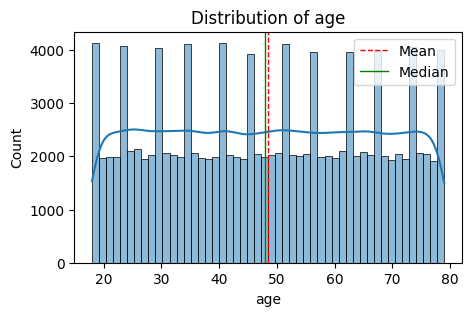

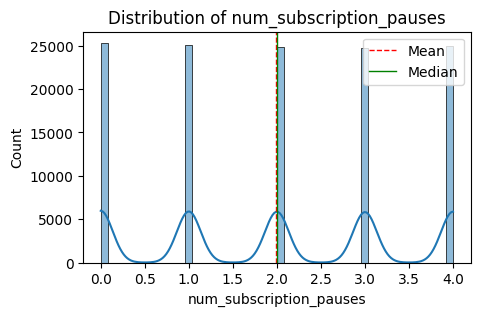

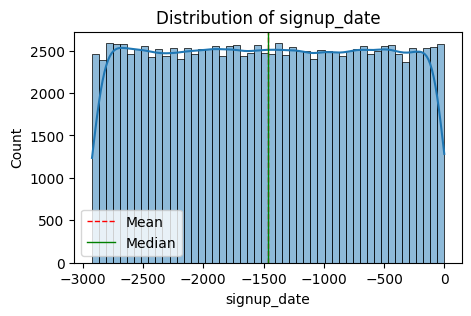

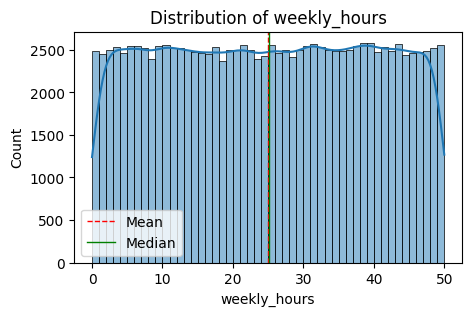

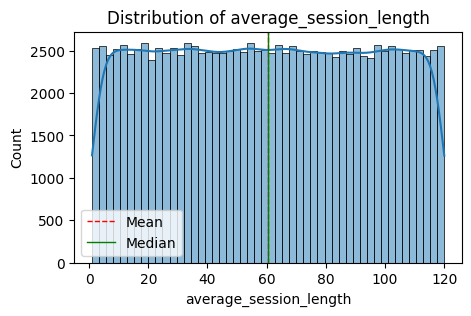

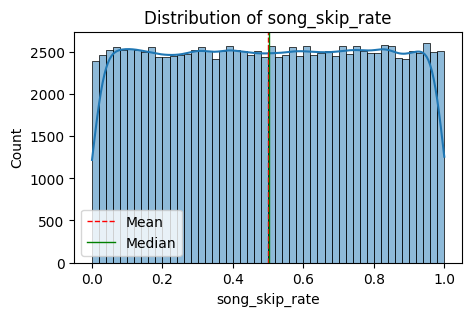

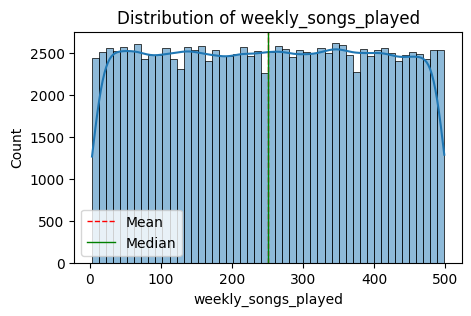

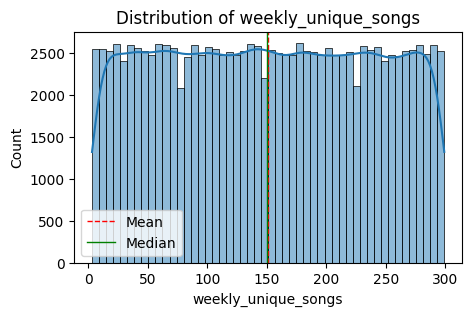

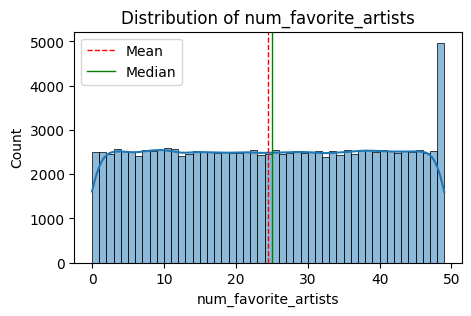

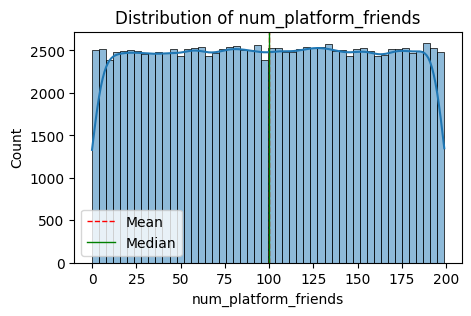

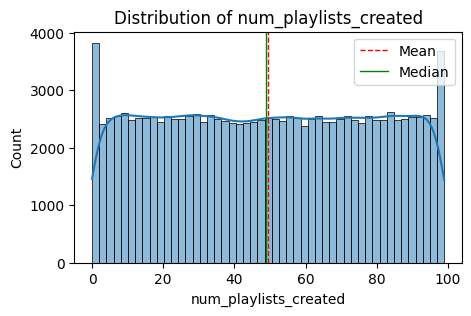

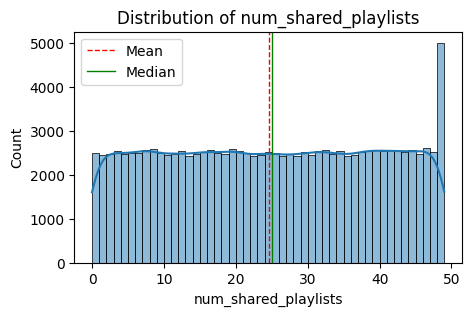

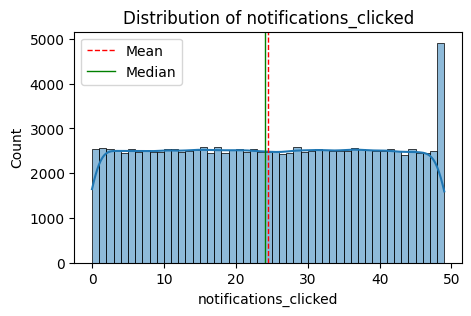

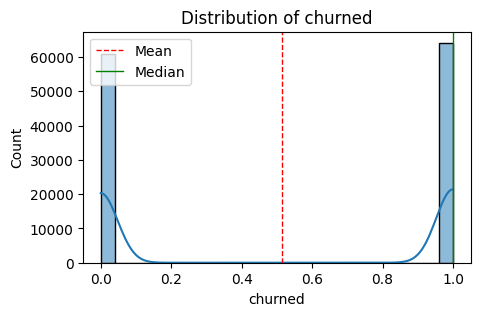

In [11]:
numerical_columns = ['age', 'num_subscription_pauses', 'signup_date', 'weekly_hours', 'average_session_length', 'song_skip_rate', 'weekly_songs_played', 'weekly_unique_songs', 'num_favorite_artists', 'num_platform_friends', 'num_playlists_created', 'num_shared_playlists', 'notifications_clicked', 'churned']
for column in numerical_columns:
    plot_histogram(df, column)

In [12]:
def boxplot(df, column):
    plt.figure(figsize=(5, 3))
    sns.boxplot(y=df[column])
    plt.title(f"Box plot of {column}")
    plt.show()

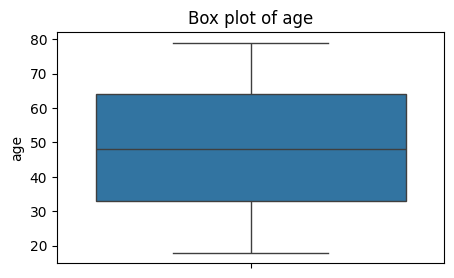

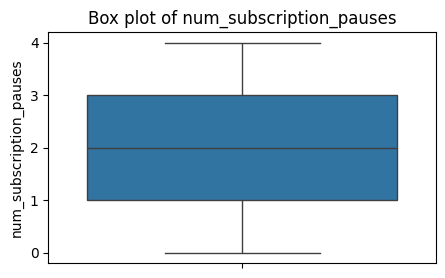

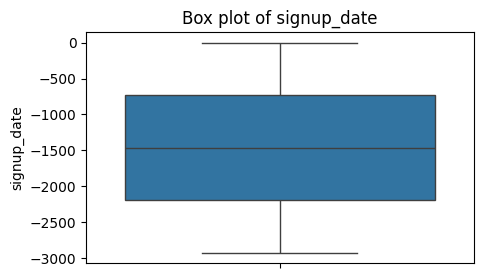

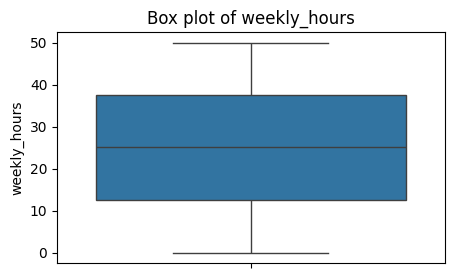

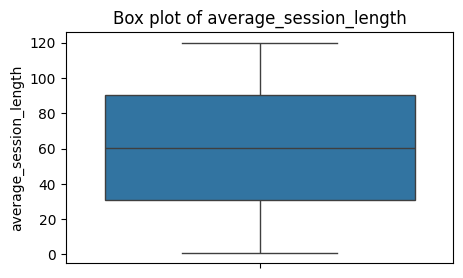

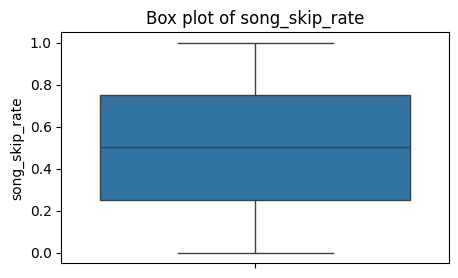

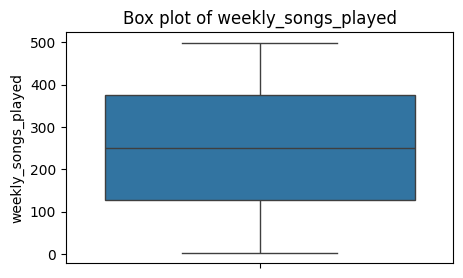

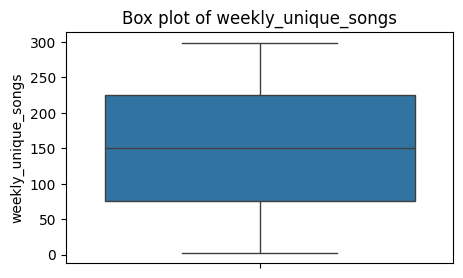

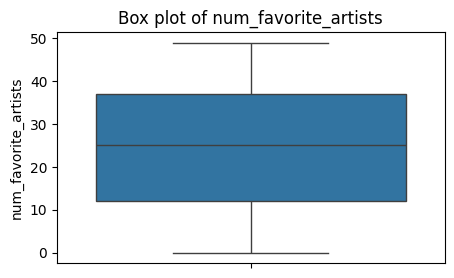

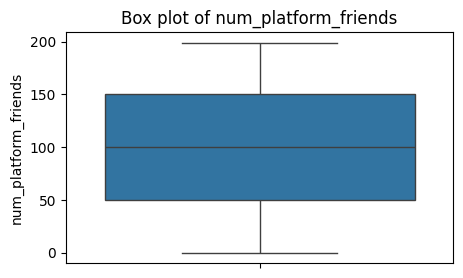

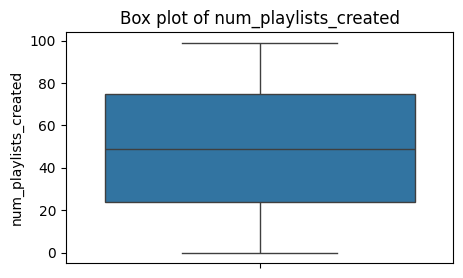

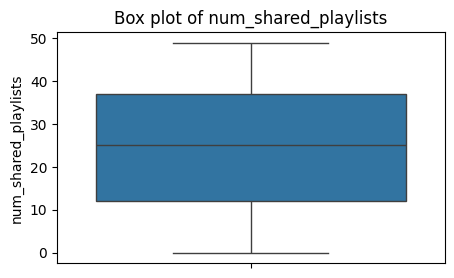

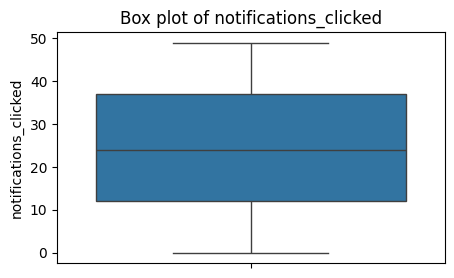

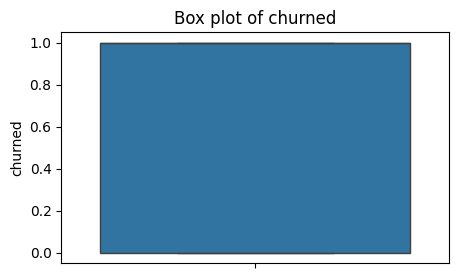

In [13]:
for column in numerical_columns:
    boxplot(df, column)

In [14]:
# by the boxplots we can say there is no outliers and its a uniform distribution

### Correlation Heat Map for numerical columns 

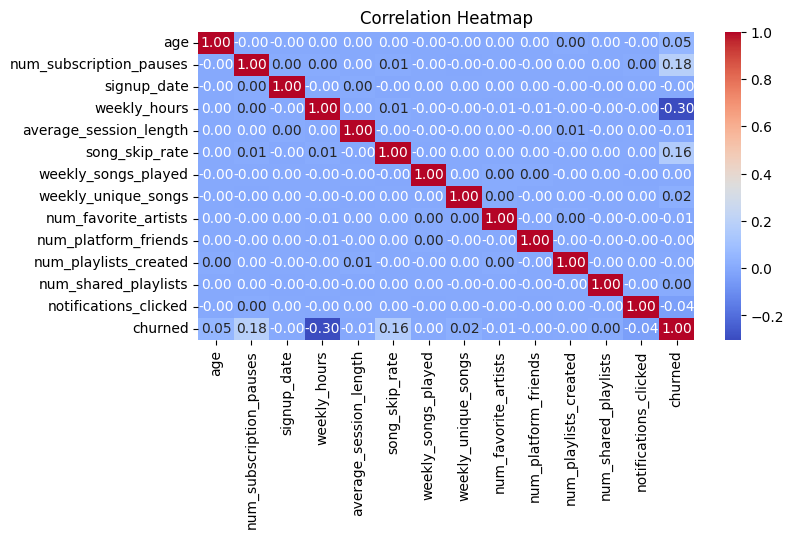

In [15]:
plt.figure(figsize=(8,4))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Categorical features - Analysis

In [16]:
df.columns

Index(['age', 'location', 'subscription_type', 'payment_plan',
       'num_subscription_pauses', 'payment_method',
       'customer_service_inquiries', 'signup_date', 'weekly_hours',
       'average_session_length', 'song_skip_rate', 'weekly_songs_played',
       'weekly_unique_songs', 'num_favorite_artists', 'num_platform_friends',
       'num_playlists_created', 'num_shared_playlists',
       'notifications_clicked', 'churned'],
      dtype='object')

In [17]:
categorical_features = ['location', 'subscription_type', 'payment_plan', 'payment_method', 'customer_service_inquiries','churned']

In [18]:
# countplot for categorical features
def countplot(df, column):
    plt.figure(figsize=(5, 3))
    sns.countplot(x=df[column])
    plt.title(f"Countplot of {column}")
    plt.show()

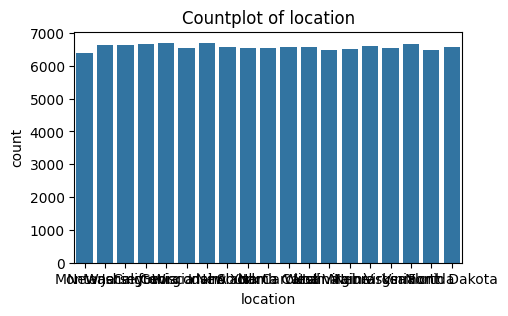

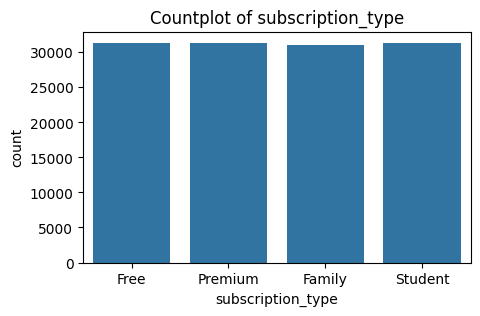

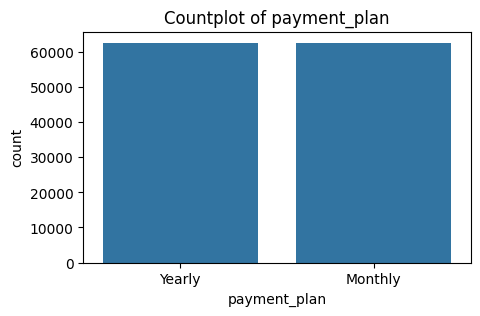

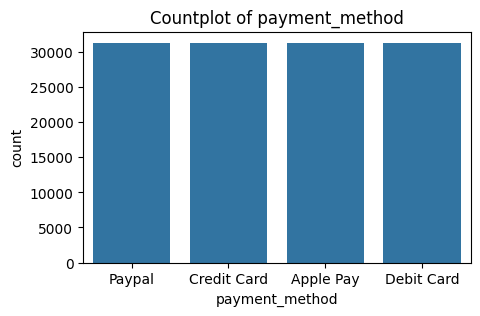

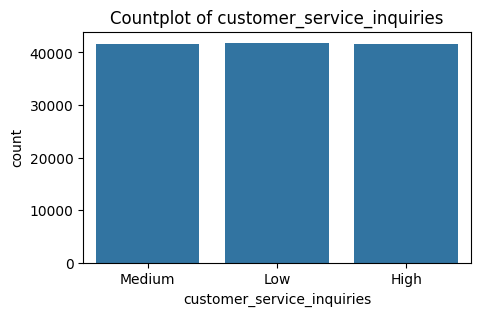

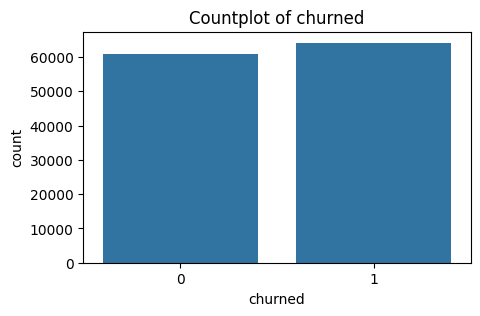

In [19]:
for column in categorical_features:
    countplot(df, column)

In [20]:
# catergorical fetaure distribution are balanced

# 4. Data Pre-processing

In [21]:
df.head(2)

,age,location,subscription_type,payment_plan,num_subscription_pauses,payment_method,customer_service_inquiries,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,num_shared_playlists,notifications_clicked,churned
0,32,Montana,Free,Yearly,2,Paypal,Medium,-1606,22.391362,105.394516,0.176873,169,109,18,32,52,35,46,0
1,64,New Jersey,Free,Monthly,3,Paypal,Low,-2897,29.294210,52.501115,0.981811,55,163,44,33,12,25,37,1


In [22]:
encoders = {}
for column in categorical_features:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])
    encoders[column] = label_encoder

In [23]:
df.head(5)

,age,location,subscription_type,payment_plan,num_subscription_pauses,payment_method,customer_service_inquiries,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,num_shared_playlists,notifications_clicked,churned
0,32,6,1,1,2,3,2,-1606,22.391362,105.394516,0.176873,169,109,18,32,52,35,46,0
1,64,8,1,0,3,3,1,-2897,29.294210,52.501115,0.981811,55,163,44,33,12,25,37,1
2,51,16,2,1,2,1,0,-348,15.400312,24.703696,0.048411,244,117,20,129,50,28,38,0
3,63,1,0,1,4,0,2,-2894,22.842084,83.595480,0.035691,442,252,47,120,55,17,24,0
4,54,16,0,0,3,3,0,-92,23.151163,52.578266,0.039738,243,230,41,66,40,32,47,0


In [24]:
# splitting the features and target
X = df.iloc[:, :-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
print(X_train.shape, X_test.shape)

(100000, 18) (25000, 18)


# 5. Model Training

In [26]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
}

In [27]:
cv_scores = {}
for model_name, model in models.items():
    print(f"Training {model_name} with default params")
    scores = cross_val_score(model, X_train, y_train, cv=8, scoring="accuracy")
    cv_scores[model_name] = scores
    print(f"{model_name} cross-validation accuracy is {np.mean(scores):.2f}") 
    print("*"*50)

Training Decision Tree with default params
Decision Tree cross-validation accuracy is 0.80
**************************************************
Training Random Forest with default params
Random Forest cross-validation accuracy is 0.85
**************************************************
Training XGBoost with default params
XGBoost cross-validation accuracy is 0.85
**************************************************


In [28]:
cv_scores

{'Decision Tree': array([0.80032, 0.80608, 0.80488, 0.78856, 0.79808, 0.79552, 0.80112,
        0.79256]),
 'Random Forest': array([0.8508 , 0.84872, 0.84664, 0.83952, 0.8436 , 0.84752, 0.84704,
        0.84616]),
 'XGBoost': array([0.84736, 0.84656, 0.84856, 0.84488, 0.84464, 0.8504 , 0.85272,
        0.8432 ])}

In [29]:
# lets train xgboost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [30]:
y_pred = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.84404
              precision    recall  f1-score   support

           0       0.84      0.85      0.84     12163
           1       0.85      0.84      0.85     12837

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



In [31]:
# lets do hyperparameter tuning for XGBoost

In [32]:
param_grid_xgb = {
    'n_estimators': randint(100, 500),      
    'learning_rate': uniform(0.01, 0.19),   
    'max_depth': randint(3, 10),          
    'subsample': uniform(0.6, 0.4),        
    'colsample_bytree': uniform(0.6, 0.4),    
    'gamma': randint(0, 5),              
    'lambda': randint(0, 10),            
    'alpha': randint(0, 10)               
}

In [33]:
print(f"Tuning XGBoost")
random_search = RandomizedSearchCV(XGBClassifier(random_state=42), param_grid_xgb, n_iter=20, cv=5, scoring='accuracy', n_jobs=4)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Tuning XGBoost
Best Parameters: {'alpha': 2, 'colsample_bytree': np.float64(0.7349046057379026), 'gamma': 1, 'lambda': 6, 'learning_rate': np.float64(0.05972360330142587), 'max_depth': 9, 'n_estimators': 229, 'subsample': np.float64(0.7378451361155505)}
Best Score: 0.84925


In [34]:
explainer = shap.Explainer(xgb_model) 
shap_values = explainer(X_train) 

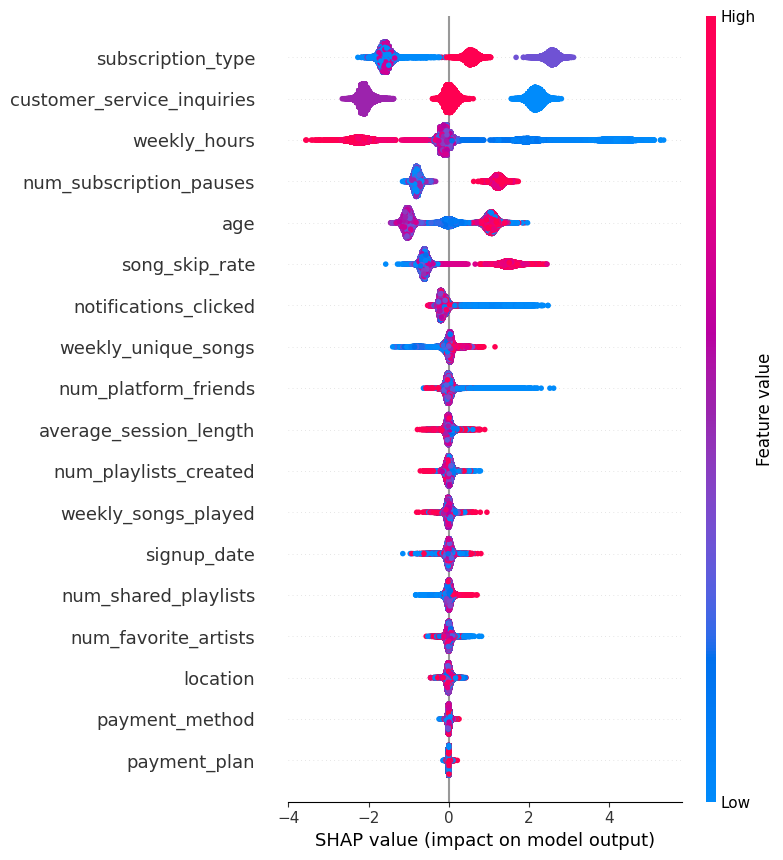

In [35]:
shap.summary_plot(shap_values, X_train)

In [36]:
dropping_columns = ['num_platform_friends', 'average_session_length', 'num_playlists_created',
                    'weekly_songs_played', 'signup_date', 'num_shared_playlists', 'num_favorite_artists',
                    'location', 'payment_method', 'payment_plan', 'notifications_clicked', 'weekly_unique_songs']
df = df.drop(columns=dropping_columns)
df.head(5)

,age,subscription_type,num_subscription_pauses,customer_service_inquiries,weekly_hours,song_skip_rate,churned
0,32,1,2,2,22.391362,0.176873,0
1,64,1,3,1,29.294210,0.981811,1
2,51,2,2,0,15.400312,0.048411,0
3,63,0,4,2,22.842084,0.035691,0
4,54,0,3,0,23.151163,0.039738,0


In [37]:
# splitting the features and target
X = df.iloc[:, :-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
print(X_train.shape, X_test.shape)

(100000, 6) (25000, 6)


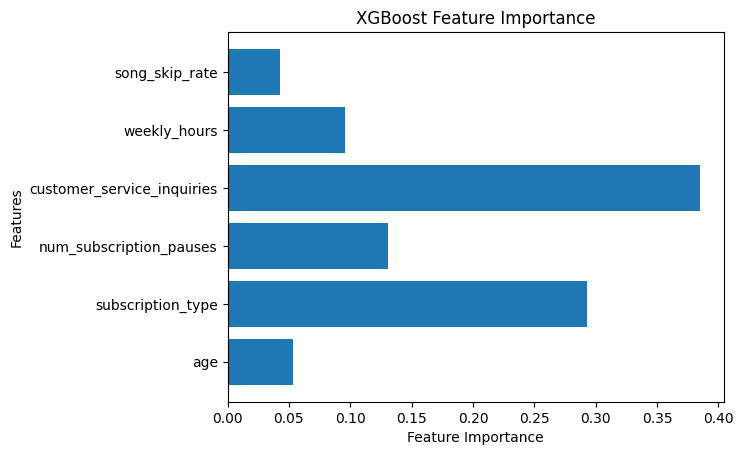

In [39]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
plt.barh(X_train.columns, xgb_model.feature_importances_)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()

In [40]:
y_pred = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8416
              precision    recall  f1-score   support

           0       0.84      0.83      0.84     12163
           1       0.84      0.86      0.85     12837

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



In [41]:
print(f"Tuning XGBoost")
random_search = RandomizedSearchCV(XGBClassifier(random_state=42), param_grid_xgb, n_iter=20, cv=5, scoring='accuracy', n_jobs=4)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Tuning XGBoost
Best Parameters: {'alpha': 3, 'colsample_bytree': np.float64(0.7168169631443062), 'gamma': 2, 'lambda': 1, 'learning_rate': np.float64(0.11485672406332129), 'max_depth': 3, 'n_estimators': 476, 'subsample': np.float64(0.6928588436548554)}
Best Score: 0.8446
